# Project Title: Rossmann Sales Prediction
### Name: Sai Charan Desireddy
### Date: 2/12/2024

## Breif Description: :

We are given historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

### Data fields
The following are descriptions for those that aren't.

* **`Id`** - an Id that represents a (Store, Date) duple within the test set
* **`Store`** - a unique Id for each store
* **`Sales`** - the turnover for any given day (this is what you are predicting)
* **`Customers`** - the number of customers on a given day
* **`Open`** - an indicator for whether the store was open: 0 = closed, 1 = open
* **`StateHoliday`** - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* **`SchoolHoliday`** - indicates if the (Store, Date) was affected by the closure of public schools
* **`StoreType`** - differentiates between 4 different store models: a, b, c, d
* **`Assortment`** - describes an assortment level: a = basic, b = extra, c = extended
* **`CompetitionDistance`** - distance in meters to the nearest competitor store
* **`CompetitionOpenSince[Month/Year]`** - gives the approximate year and month of the time the nearest competitor was opened
* **`Promo`** - indicates whether a store is running a promo on that day
* **`Promo2`** - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* **`Promo2Since[Year/Week]`** - describes the year and calendar week when the store started participating in Promo2
* **`PromoInterval`** - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

### Import libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

/kaggle/input/rossmann-store-sales/sample_submission.csv
/kaggle/input/rossmann-store-sales/store.csv
/kaggle/input/rossmann-store-sales/train.csv
/kaggle/input/rossmann-store-sales/test.csv


### Load datasets

In [ ]:
#load all datasets
store_df = pd.read_csv('Data/store.csv')
train_df = pd.read_csv('Data/train.csv')

/tmp/ipykernel_30/3114421857.py:5: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv('/kaggle/input/rossmann-store-sales/train.csv')


In the sample_submission csv, there is such data which is realted to our problem statment, so we can skip this.

In [ ]:
store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [ ]:
train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


As train and test data contains sales data,, and the stores data contains its competetor and other details, so we need to merge train+store and test+store on store column(store column is common on both datasets).

And we don't have Sales column in test data, so we can skip that test data, and move on with train data.

### Pre-process and Feature Engineering

In [ ]:
merged_train_df = train_df.merge(store_df, how='left', on='Store')
merged_train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


Now we have successfully merged train+store.

In [ ]:
print("Merged train data shape is: ", merged_train_df.shape)

Merged train data shape is:  (1017209, 18)


In [ ]:
print(merged_train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

In [ ]:
print(merged_train_df.isnull().sum())

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
dtype: int64


In [ ]:
merged_train_df.CompetitionDistance.nunique()

654

Since the Competetion diatsnce column values are null becuase they don't have comptetion for those stores, so we can replace them with Zer(0)

In [ ]:
merged_train_df['CompetitionDistance'].fillna(0, inplace=True)
print('Null  values of CompetitionDistance in train dataset: ', merged_train_df.CompetitionDistance.isna().sum())

Null  values of CompetitionDistance in train dataset:  0


/tmp/ipykernel_30/289113731.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_train_df['CompetitionDistance'].fillna(0, inplace=True)


In [ ]:
print('train data: ')
merged_train_df.isnull().sum()

train data: 


Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance               0
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
dtype: int64

Let's fill null values of 'CompetitionOpenSinceMonth' and 'CompetitionOpenSinceYear' with mode(number that occurs most often)

In [ ]:
merged_train_df['CompetitionOpenSinceMonth'].mode()

0    9.0
Name: CompetitionOpenSinceMonth, dtype: float64

In [ ]:
train_competition_month = merged_train_df['CompetitionOpenSinceMonth'].mode()[0]
train_competition_year = merged_train_df['CompetitionOpenSinceYear'].mode()[0]
merged_train_df['CompetitionOpenSinceMonth'] = merged_train_df['CompetitionOpenSinceMonth'].fillna(train_competition_month)
merged_train_df['CompetitionOpenSinceYear'] = merged_train_df['CompetitionOpenSinceYear'].fillna(train_competition_year)

In [ ]:
merged_train_df.isnull().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance               0
CompetitionOpenSinceMonth         0
CompetitionOpenSinceYear          0
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
dtype: int64

If other columns, Promos are null means they didn't continued their promotino, they stopped with promo1. So we can repalce null values with 0

In [ ]:
merged_train_df['Promo2SinceWeek'].fillna(0, inplace=True)
merged_train_df['Promo2SinceYear'].fillna(0, inplace=True)
merged_train_df['PromoInterval'].fillna(0, inplace=True)

/tmp/ipykernel_30/3461977129.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_train_df['Promo2SinceWeek'].fillna(0, inplace=True)
/tmp/ipykernel_30/3461977129.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

In [ ]:
print("Null values of train data column")
merged_train_df.isnull().sum()

Null values of train data column


Store                        0
DayOfWeek                    0
Date                         0
Sales                        0
Customers                    0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

Now, we can split the 'Date' column into seperate columns as 'Day', 'Month', 'Year'.

In [ ]:
merged_train_df.Date.dtype

dtype('O')

So first we need to convert the Data column data type into date, and then split into new columns

In [ ]:
merged_train_df['Date'] = pd.to_datetime(merged_train_df.Date)

In [ ]:
merged_train_df.Date.dtype

dtype('<M8[ns]')

In [ ]:
merged_train_df['Day'] = merged_train_df.Date.dt.day
merged_train_df['Month'] = merged_train_df.Date.dt.month
merged_train_df['Year'] = merged_train_df.Date.dt.year

In [ ]:
merged_train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Day,Month,Year
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,1270.0,9.0,2008.0,0,0.0,0.0,0,31,7,2015
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",31,7,2015
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",31,7,2015
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,...,620.0,9.0,2009.0,0,0.0,0.0,0,31,7,2015
4,5,5,2015-07-31,4822,559,1,1,0,1,a,...,29910.0,4.0,2015.0,0,0.0,0.0,0,31,7,2015


We splitted Date column into date, month and year. So we can drop date column

In [ ]:
merged_train_df = merged_train_df.drop('Date', axis=1)

In [ ]:
merged_train_df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Day,Month,Year
0,1,5,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,31,7,2015
1,2,5,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",31,7,2015
2,3,5,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",31,7,2015
3,4,5,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,0.0,0.0,0,31,7,2015
4,5,5,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0,31,7,2015


In [ ]:
merged_train_df.duplicated().sum()

0

the train data is ready

In [ ]:
merged_train_df.head(2)

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Day,Month,Year
0,1,5,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,31,7,2015
1,2,5,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",31,7,2015


stateholiday, storetype, assortment, promointerval not provide more details while training, so we can drop them.

In [ ]:
merged_train_df.drop(columns=['StateHoliday', 'StoreType', 'Assortment', 'PromoInterval'], axis=1, inplace=True)
merged_train_df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Day,Month,Year
0,1,5,5263,555,1,1,1,1270.0,9.0,2008.0,0,0.0,0.0,31,7,2015
1,2,5,6064,625,1,1,1,570.0,11.0,2007.0,1,13.0,2010.0,31,7,2015
2,3,5,8314,821,1,1,1,14130.0,12.0,2006.0,1,14.0,2011.0,31,7,2015
3,4,5,13995,1498,1,1,1,620.0,9.0,2009.0,0,0.0,0.0,31,7,2015
4,5,5,4822,559,1,1,1,29910.0,4.0,2015.0,0,0.0,0.0,31,7,2015


Columns like 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', and 'Promo2SinceYear' are in float dtype, so we can convert those into int

### EDA

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


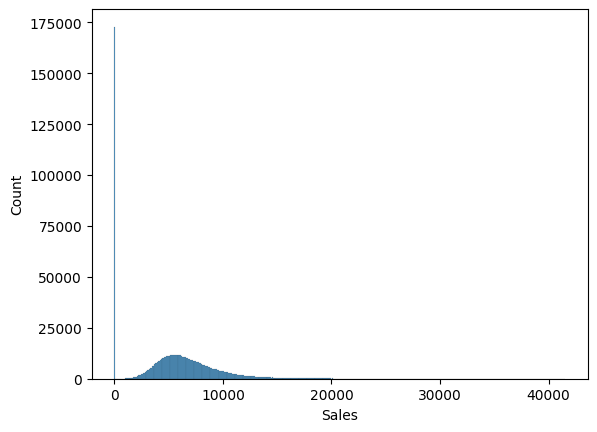

In [ ]:
sns.histplot(data=merged_train_df, x='Sales');

<Axes: xlabel='DayOfWeek', ylabel='Sales'>

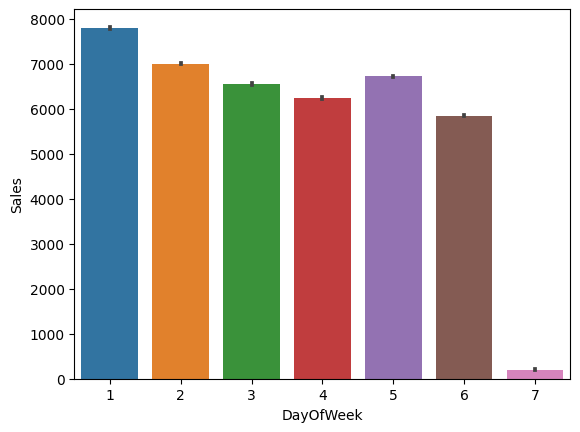

In [ ]:
sns.barplot(data=merged_train_df, x='DayOfWeek', y='Sales')

<Axes: xlabel='Month', ylabel='Sales'>

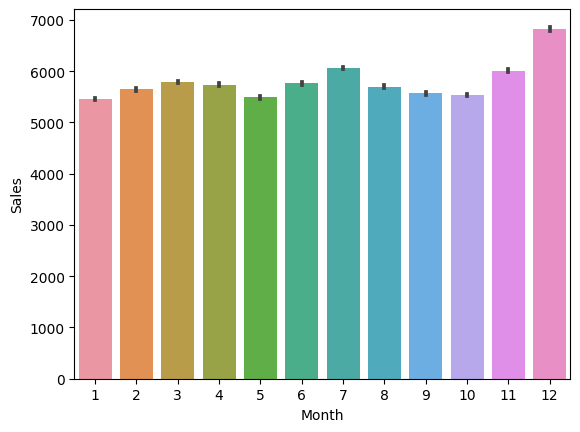

In [ ]:
sns.barplot(data=merged_train_df, x='Month', y='Sales')

<Axes: xlabel='Year', ylabel='Sales'>

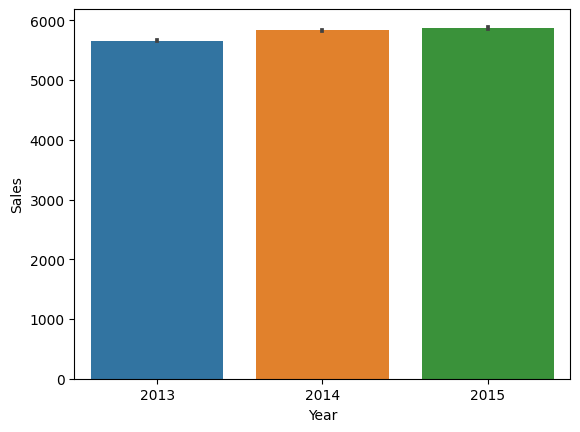

In [ ]:
sns.barplot(data=merged_train_df, x='Year', y='Sales')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

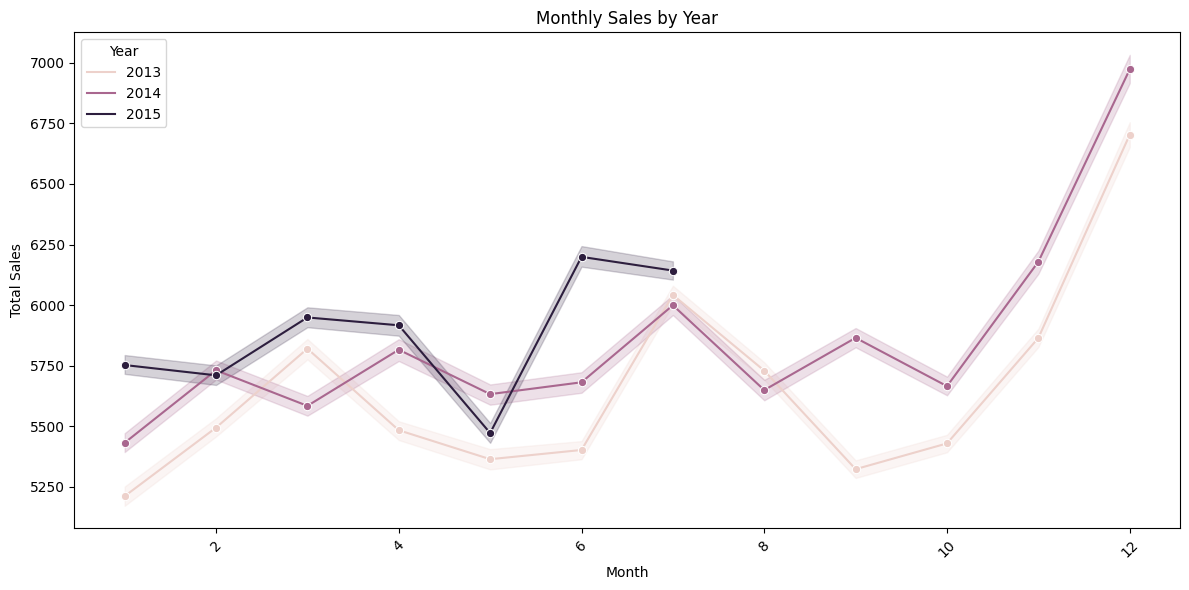

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=merged_train_df, x='Month', y='Sales', hue='Year', marker='o')
plt.title('Monthly Sales by Year')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.legend(title='Year')
plt.tight_layout()
plt.show()

### Model Training with Decision Tree

In [ ]:
# Define features (X) and target variable (y)
X = merged_train_df.drop('Sales',axis=1)
y = merged_train_df['Sales']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:

# Create a Decision Tree Regressor (or Classifier)
model = DecisionTreeRegressor(random_state=42)  # Use DecisionTreeClassifier for classification tasks

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model (for regression)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

Mean Squared Error: 435495.1707808614
R^2 Score: 0.9705523583043264


Since, the model is performing well, but MSE value is very high and not good at precisting th ecorrect sales value. So let's apply a transpfrmation on output column. We can apply Box-Cox transofrmation(ensure all values are positive), as we have all positive of sales.

### Optimization

In [ ]:
merged_train_df['Sales'] = merged_train_df['Sales'] + 1

# Apply Box-Cox transformation
merged_train_df['Sales'], lambda_value = stats.boxcox(merged_train_df['Sales'])

In [ ]:
# Define features (X) and target variable (y)
X = merged_train_df.drop('Sales',axis=1)
y = merged_train_df['Sales']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:

# Create a Decision Tree Regressor (or Classifier)
model = DecisionTreeRegressor(random_state=42)  # Use DecisionTreeClassifier for classification tasks

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model (for regression)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

Mean Squared Error: 30.182707281202536
R^2 Score: 0.9903870325398278


### Model Training with Random Forest

In [ ]:
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Evaluate Random Forest model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f'Random Forest MSE: {mse_rf}')
print(f'Random Forest R^2 Score: {r2_rf}')

Random Forest MSE: 15.045561747949511
Random Forest R^2 Score: 0.9952081006466532


### Model Prediction

In [ ]:
# Create a DataFrame to show original and predicted sales
results_df = pd.DataFrame({
    'Original Sales': y_test.reset_index(drop=True),  # Reset index to align with predictions
    'Predicted Sales': y_pred_rf
})

print("Results DataFrame:")
print(results_df)

Results DataFrame:
        Original Sales  Predicted Sales
0             0.000000         0.000000
1           122.507932       124.550386
2           141.296757       143.051185
3            96.206089        99.312835
4           173.155612       167.734385
...                ...              ...
203437      153.059882       148.019172
203438      175.332932       176.524297
203439       96.413313        93.109743
203440        0.000000         0.000000
203441      199.743982       194.524667

[203442 rows x 2 columns]


In [ ]:
results_df.head(20)

,Original Sales,Predicted Sales
0,0.000000,0.000000
1,122.507932,124.550386
2,141.296757,143.051185
3,96.206089,99.312835
4,173.155612,167.734385
5,0.000000,0.000000
6,191.740653,194.987510
7,130.216025,132.333929
8,166.488002,174.186666
9,143.511237,149.236696
